In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import hydroeval as he
import xlsxwriter

# from sklearn.decomposition import PCA


In [2]:
# Create excel file
workbook = xlsxwriter.Workbook('MLP.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write('B1', 'Q_eff')
worksheet.write('C1', 'Temp_eff')
worksheet.write('D1', 'pH_eff')
worksheet.write('E1', 'COD_eff')
worksheet.write('F1', 'BOD_eff')
worksheet.write('G1', 'TSS_eff')
worksheet.write('H1', 'NH4_eff')
worksheet.write('I1', 'TN_eff')
worksheet.write('J1', 'PO4_eff')
worksheet.write('K1', 'TP_eff')
worksheet.write('L1', 'FC_eff')

worksheet.write('A2', 'MAPE_train')
worksheet.write('A3', 'MAPE_test')
worksheet.write('A4', 'R2_train')
worksheet.write('A5', 'R2_test')
worksheet.write('A6', 'NSE_train')
worksheet.write('A7', 'NSE_test')

0

In [3]:
#Loading data
data = pd.read_excel("C:/Users/sh/Desktop/term 3 ut/Thesis and Paper/R/New folder/WWTP_data_jadid.xlsx")
data

,Q_eff,Temp_eff,pH_eff,COD_eff,BOD_eff,TSS_eff,NH4_eff,TN_eff,PO4_eff,TP_eff,...,MLSS_AT,DO_AT,MLSS_re,EC_in,Temp_air_avg,Temp_air_min,Temp_air_max,Rain,Wind,Humidity
0,332402.0,23.0,6.52,16.0,3.0,8.0,11.2,12.6,NaN,NaN,...,3717.500000,1.39,6630.0,1158.56,1.0,-2.0,5.0,1.02,8.0,60.0
1,372540.0,23.0,6.58,24.0,5.0,6.0,8.4,26.0,NaN,NaN,...,3675.000000,1.14,5580.0,1474.43,1.0,-2.0,3.0,0.00,3.0,82.0
2,392705.0,23.0,6.61,25.0,4.0,8.0,14.6,26.4,NaN,NaN,...,3765.000000,1.10,6130.0,1363.70,2.0,-1.0,6.0,0.00,6.0,70.0
3,373491.0,23.0,6.71,41.0,5.0,12.0,16.0,24.4,NaN,NaN,...,3707.500000,0.92,6950.0,1446.77,3.0,0.0,6.0,0.00,6.0,59.0
4,393104.0,23.0,6.69,28.0,9.0,16.0,18.0,26.4,NaN,NaN,...,4130.000000,0.95,6840.0,1429.97,1.0,-1.0,4.0,0.00,5.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,393600.0,24.0,6.97,29.0,NaN,12.0,11.2,18.7,NaN,NaN,...,2333.750000,1.21,7650.0,2008.05,9.0,6.0,13.0,0.00,13.0,65.0
688,392664.0,25.0,7.05,75.0,NaN,30.0,8.0,25.0,NaN,NaN,...,3643.750000,0.93,7190.0,2008.05,8.0,3.0,13.0,0.00,6.0,56.0
689,371064.0,24.0,7.00,34.0,NaN,14.0,20.0,20.5,NaN,NaN,...,3788.750000,2.49,7190.0,2008.05,9.0,5.0,14.0,0.00,6.0,43.0
690,343800.0,24.0,6.86,38.0,NaN,14.0,16.6,20.6,3.67,3.98,...,3773.750000,2.37,7220.0,2008.05,11.0,5.0,17.0,0.00,6.0,18.0


In [4]:
# Copy data
data_with_missing_value = data.copy()

# replace missing values with mean of columns
for var in data:
    data[var] = data[var].replace(np.nan,
                                  data[var].mean())
    
# Read column names of data and use it as input(x) and output(y) variables
x = data[['Q_in',
          'Temp_in',
          'pH_in',
          'COD_in',
          'BOD_in',
          'TSS_in',
          'NH4_in',
          'TN_in',
          'PO4_in',
          'TP_in',
          'MLSS_AT',
          'DO_AT',
          'MLSS_re',
          'EC_in',
          'Temp_air_avg',
          'Temp_air_min',
          'Temp_air_max',
          'Rain',
          'Wind',
          'Humidity']].to_numpy()

output_variables = ['Q_eff',
                    'Temp_eff',
                    'pH_eff',
                    'COD_eff',
                    'BOD_eff',
                    'TSS_eff',
                    'NH4_eff',
                    'TN_eff',
                    'PO4_eff',
                    'TP_eff',
                    'FC_eff']

In [5]:
column = 1

for target in output_variables:
    
    y = data[[target]].to_numpy()
    
    X = MinMaxScaler().fit_transform(x)
    Y = MinMaxScaler().fit_transform(y)
    
    # splitting data into train and test
    trn_tst_split = int(0.8*len(data))
    X_train = X[0:trn_tst_split]
    Y_train = Y[0:trn_tst_split]
    X_test = X[trn_tst_split:]
    Y_test = Y[trn_tst_split:]
    
    mlp = MLPRegressor(hidden_layer_sizes=(3),
                       activation= 'tanh',
                       solver='sgd',
                       batch_size=5,
                       learning_rate='adaptive',
                       learning_rate_init=0.15,
                       max_iter=3000,
                       shuffle=True,
                       tol=0.0000000000000000001,
                       verbose=True,
                       momentum=0.9,
                       alpha=0.0001,
                       warm_start=True,
                       validation_fraction=0.1)
    
    mlp.fit(X_train, Y_train.ravel())
    
    # Predict target variable in train and test dataset
    predict_train = mlp.predict(X_train)
    predict_test = mlp.predict(X_test)
    
    # Calculate the accuracy of prediction model
    R2_train = metrics.r2_score(Y_train,
                                predict_train)
    R2_test  = metrics.r2_score(Y_test,
                                predict_test)
    
    MAPE_train = metrics.mean_absolute_percentage_error(Y_train,
                                                        predict_train)
    MAPE_test  = metrics.mean_absolute_percentage_error(Y_test,
                                                        predict_test)
    
    nse_train = he.evaluator(he.nse,
                             Y_train,
                             predict_train)
    nse_test  = he.evaluator(he.nse,
                             Y_test,
                             predict_test)
    
    if R2_test <= 0:
        corr_matrix_test = np.corrcoef(np.reshape(Y_test,
                                                  len(Y_test)),
                                       np.reshape(predict_test,
                                                  len(predict_test)))
        R2_test = corr_matrix_test[0,1]**2
        
    if R2_train <= 0:
        corr_matrix_train = np.corrcoef(np.reshape(Y_train,
                                                   len(Y_train)),
                                        np.reshape(predict_train,
                                                   len(predict_train)))
        R2_train = corr_matrix_train[0,1]**2
        
    # write on excel file
    row = 1
    indices = [round(MAPE_train,2),
               round(MAPE_test,2),
               round(R2_train,2),
               round(R2_test,2),
               round(nse_train[0],2),
               round(nse_test[0],2)]
    
    # iterating through indices list
    for item in indices:
        worksheet.write(row, column, item)
        row += 1
               
    column += 1
        
workbook.close()

Iteration 1, loss = 0.01973493
Iteration 2, loss = 0.00750061
Iteration 3, loss = 0.00612135
Iteration 4, loss = 0.00471427
Iteration 5, loss = 0.00313605
Iteration 6, loss = 0.00219717
Iteration 7, loss = 0.00192930
Iteration 8, loss = 0.00173098
Iteration 9, loss = 0.00163315
Iteration 10, loss = 0.00160931
Iteration 11, loss = 0.00161794
Iteration 12, loss = 0.00150972
Iteration 13, loss = 0.00154322
Iteration 14, loss = 0.00146984
Iteration 15, loss = 0.00156233
Iteration 16, loss = 0.00149492
Iteration 17, loss = 0.00153333
Iteration 18, loss = 0.00144437
Iteration 19, loss = 0.00152446
Iteration 20, loss = 0.00159749
Iteration 21, loss = 0.00139363
Iteration 22, loss = 0.00150009
Iteration 23, loss = 0.00153000
Iteration 24, loss = 0.00148822
Iteration 25, loss = 0.00142800
Iteration 26, loss = 0.00142587
Iteration 27, loss = 0.00143207
Iteration 28, loss = 0.00149351
Iteration 29, loss = 0.00144330
Iteration 30, loss = 0.00145902
Iteration 31, loss = 0.00147986
Iteration 32, los

Iteration 38, loss = 0.00373688
Iteration 39, loss = 0.00364897
Iteration 40, loss = 0.00363959
Iteration 41, loss = 0.00366471
Iteration 42, loss = 0.00360210
Iteration 43, loss = 0.00367773
Iteration 44, loss = 0.00381049
Iteration 45, loss = 0.00358268
Iteration 46, loss = 0.00367183
Iteration 47, loss = 0.00358881
Iteration 48, loss = 0.00359589
Iteration 49, loss = 0.00364760
Iteration 50, loss = 0.00369061
Iteration 51, loss = 0.00378534
Iteration 52, loss = 0.00356865
Iteration 53, loss = 0.00366043
Iteration 54, loss = 0.00363198
Iteration 55, loss = 0.00359130
Iteration 56, loss = 0.00377462
Iteration 57, loss = 0.00355635
Iteration 58, loss = 0.00372733
Iteration 59, loss = 0.00374508
Iteration 60, loss = 0.00354477
Iteration 61, loss = 0.00363252
Iteration 62, loss = 0.00354142
Iteration 63, loss = 0.00363037
Iteration 64, loss = 0.00368885
Iteration 65, loss = 0.00352578
Iteration 66, loss = 0.00362808
Iteration 67, loss = 0.00361014
Iteration 68, loss = 0.00357884
Iteratio

Iteration 32, loss = 0.00471056
Iteration 33, loss = 0.00468557
Iteration 34, loss = 0.00451943
Iteration 35, loss = 0.00439342
Iteration 36, loss = 0.00463965
Iteration 37, loss = 0.00449816
Iteration 38, loss = 0.00446684
Iteration 39, loss = 0.00449398
Iteration 40, loss = 0.00430668
Iteration 41, loss = 0.00435655
Iteration 42, loss = 0.00423786
Iteration 43, loss = 0.00456156
Iteration 44, loss = 0.00429152
Iteration 45, loss = 0.00488822
Iteration 46, loss = 0.00440036
Iteration 47, loss = 0.00436811
Iteration 48, loss = 0.00441847
Iteration 49, loss = 0.00441098
Iteration 50, loss = 0.00452700
Iteration 51, loss = 0.00428088
Iteration 52, loss = 0.00427748
Iteration 53, loss = 0.00460753
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.030000
Iteration 54, loss = 0.00409137
Iteration 55, loss = 0.00362592
Iteration 56, loss = 0.00365862
Iteration 57, loss = 0.00353442
Iteration 58, loss = 0.00363280
Iteration 59, loss = 0

Iteration 65, loss = 0.00357890
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.006000
Iteration 66, loss = 0.00347888
Iteration 67, loss = 0.00343231
Iteration 68, loss = 0.00343462
Iteration 69, loss = 0.00346777
Iteration 70, loss = 0.00343816
Iteration 71, loss = 0.00346030
Iteration 72, loss = 0.00346957
Iteration 73, loss = 0.00348185
Iteration 74, loss = 0.00340650
Iteration 75, loss = 0.00349098
Iteration 76, loss = 0.00341300
Iteration 77, loss = 0.00347018
Iteration 78, loss = 0.00343443
Iteration 79, loss = 0.00340898
Iteration 80, loss = 0.00344308
Iteration 81, loss = 0.00343831
Iteration 82, loss = 0.00349141
Iteration 83, loss = 0.00343821
Iteration 84, loss = 0.00343815
Iteration 85, loss = 0.00345837
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.001200
Iteration 86, loss = 0.00344296
Iteration 87, loss = 0.00340429
Iteration 88, loss = 0.00341026
Iter

Iteration 58, loss = 0.00319567
Iteration 59, loss = 0.00318861
Iteration 60, loss = 0.00319607
Iteration 61, loss = 0.00320675
Iteration 62, loss = 0.00319776
Iteration 63, loss = 0.00320614
Iteration 64, loss = 0.00320783
Iteration 65, loss = 0.00320082
Iteration 66, loss = 0.00319884
Iteration 67, loss = 0.00319565
Iteration 68, loss = 0.00319866
Iteration 69, loss = 0.00320107
Iteration 70, loss = 0.00318908
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.000240
Iteration 71, loss = 0.00320675
Iteration 72, loss = 0.00319137
Iteration 73, loss = 0.00318979
Iteration 74, loss = 0.00318661
Iteration 75, loss = 0.00318518
Iteration 76, loss = 0.00318506
Iteration 77, loss = 0.00318596
Iteration 78, loss = 0.00318667
Iteration 79, loss = 0.00318763
Iteration 80, loss = 0.00319022
Iteration 81, loss = 0.00318609
Iteration 82, loss = 0.00318559
Iteration 83, loss = 0.00318719
Iteration 84, loss = 0.00318672
Iteration 85, loss = 0

Iteration 78, loss = 0.00469305
Iteration 79, loss = 0.00456933
Iteration 80, loss = 0.00458072
Iteration 81, loss = 0.00456973
Iteration 82, loss = 0.00451779
Iteration 83, loss = 0.00462714
Iteration 84, loss = 0.00458290
Iteration 85, loss = 0.00458141
Iteration 86, loss = 0.00456177
Iteration 87, loss = 0.00457910
Iteration 88, loss = 0.00457920
Iteration 89, loss = 0.00457129
Iteration 90, loss = 0.00460359
Iteration 91, loss = 0.00457405
Iteration 92, loss = 0.00457016
Iteration 93, loss = 0.00460267
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.000240
Iteration 94, loss = 0.00455950
Iteration 95, loss = 0.00455623
Iteration 96, loss = 0.00455462
Iteration 97, loss = 0.00455450
Iteration 98, loss = 0.00455308
Iteration 99, loss = 0.00455403
Iteration 100, loss = 0.00455426
Iteration 101, loss = 0.00455757
Iteration 102, loss = 0.00455704
Iteration 103, loss = 0.00455314
Iteration 104, loss = 0.00455480
Training loss did

Iteration 152, loss = 0.00675337
Iteration 153, loss = 0.00675348
Iteration 154, loss = 0.00675360
Iteration 155, loss = 0.00675337
Iteration 156, loss = 0.00675343
Iteration 157, loss = 0.00675337
Iteration 158, loss = 0.00675339
Iteration 159, loss = 0.00675344
Iteration 160, loss = 0.00675344
Iteration 161, loss = 0.00675340
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.000002
Iteration 162, loss = 0.00675323
Iteration 163, loss = 0.00675325
Iteration 164, loss = 0.00675323
Iteration 165, loss = 0.00675326
Iteration 166, loss = 0.00675327
Iteration 167, loss = 0.00675325
Iteration 168, loss = 0.00675326
Iteration 169, loss = 0.00675328
Iteration 170, loss = 0.00675322
Iteration 171, loss = 0.00675323
Iteration 172, loss = 0.00675323
Iteration 173, loss = 0.00675323
Iteration 174, loss = 0.00675325
Iteration 175, loss = 0.00675327
Iteration 176, loss = 0.00675326
Iteration 177, loss = 0.00675325
Iteration 178, loss = 0.0067

Iteration 173, loss = 0.01418057
Iteration 174, loss = 0.01418057
Iteration 175, loss = 0.01418061
Iteration 176, loss = 0.01418057
Iteration 177, loss = 0.01418059
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.000000
Iteration 178, loss = 0.01418054
Iteration 179, loss = 0.01418052
Iteration 180, loss = 0.01418052
Iteration 181, loss = 0.01418052
Iteration 182, loss = 0.01418052
Iteration 183, loss = 0.01418052
Iteration 184, loss = 0.01418052
Iteration 185, loss = 0.01418052
Iteration 186, loss = 0.01418052
Iteration 187, loss = 0.01418052
Iteration 188, loss = 0.01418052
Iteration 189, loss = 0.01418052
Iteration 190, loss = 0.01418052
Iteration 191, loss = 0.01418053
Iteration 192, loss = 0.01418052
Iteration 193, loss = 0.01418053
Iteration 194, loss = 0.01418052
Iteration 195, loss = 0.01418053
Iteration 196, loss = 0.01418052
Iteration 197, loss = 0.01418052
Iteration 198, loss = 0.01418052
Iteration 199, loss = 0.0141

Iteration 201, loss = 0.00053269
Iteration 202, loss = 0.00053269
Iteration 203, loss = 0.00053269
Iteration 204, loss = 0.00053269
Iteration 205, loss = 0.00053269
Iteration 206, loss = 0.00053269
Iteration 207, loss = 0.00053269
Iteration 208, loss = 0.00053269
Iteration 209, loss = 0.00053269
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.000000
Iteration 210, loss = 0.00053269
Iteration 211, loss = 0.00053269
Iteration 212, loss = 0.00053269
Iteration 213, loss = 0.00053269
Iteration 214, loss = 0.00053269
Iteration 215, loss = 0.00053269
Iteration 216, loss = 0.00053269
Iteration 217, loss = 0.00053269
Iteration 218, loss = 0.00053269
Iteration 219, loss = 0.00053269
Iteration 220, loss = 0.00053269
Iteration 221, loss = 0.00053269
Iteration 222, loss = 0.00053269
Iteration 223, loss = 0.00053269
Iteration 224, loss = 0.00053269
Iteration 225, loss = 0.00053269
Iteration 226, loss = 0.00053269
Iteration 227, loss = 0.0005

Iteration 197, loss = 0.00080062
Iteration 198, loss = 0.00080073
Iteration 199, loss = 0.00080077
Iteration 200, loss = 0.00080070
Iteration 201, loss = 0.00080064
Iteration 202, loss = 0.00080071
Iteration 203, loss = 0.00080069
Iteration 204, loss = 0.00080071
Iteration 205, loss = 0.00080090
Iteration 206, loss = 0.00080082
Iteration 207, loss = 0.00080074
Iteration 208, loss = 0.00080069
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learning rate to 0.000010
Iteration 209, loss = 0.00080046
Iteration 210, loss = 0.00080055
Iteration 211, loss = 0.00080051
Iteration 212, loss = 0.00080051
Iteration 213, loss = 0.00080054
Iteration 214, loss = 0.00080052
Iteration 215, loss = 0.00080051
Iteration 216, loss = 0.00080051
Iteration 217, loss = 0.00080052
Iteration 218, loss = 0.00080053
Iteration 219, loss = 0.00080052
Iteration 220, loss = 0.00080053
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Setting learni

Iteration 168, loss = 0.01570580
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Learning rate too small. Stopping.


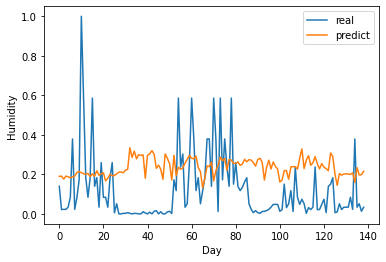

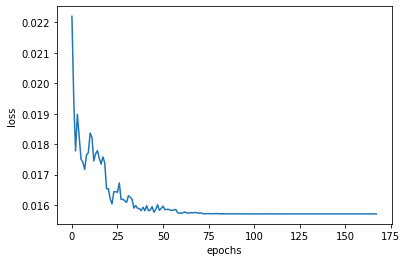

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


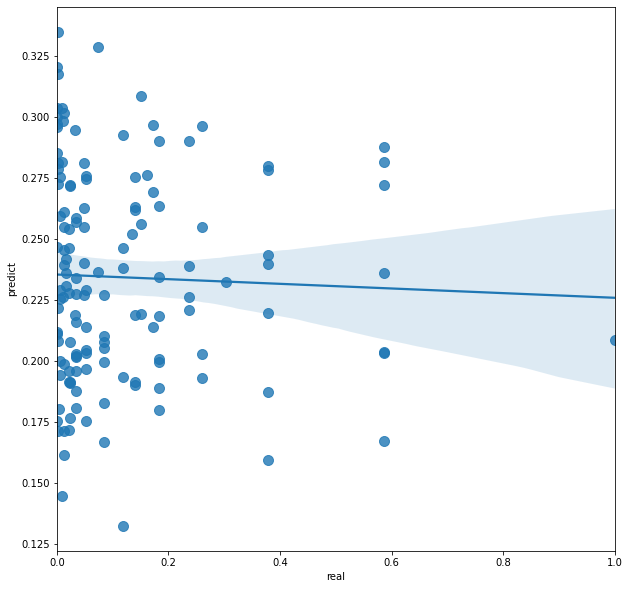

In [7]:
plt.plot(Y_test, label= 'real')
plt.plot(predict_test, label='predict')
plt.legend()
plt.xlabel('Day')
plt.ylabel(var)
plt.show()

loss = mlp.loss_curve_
plt.plot(loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(10,10))     
sns.regplot(Y_test, predict_test, fit_reg=True, scatter_kws={"s": 100})
plt.xlabel('real')
plt.ylabel('predict')
plt.show()